In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '237179',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/E8qBDKe39KEFMo-LhTNDQQ__thumb/img/jFQaWbcjoUzxS7p76LsGzg4piQk=/fit-in/200x150/filters:strip_icc()/pic6333980.jpg',
  'name': 'Weather Machine',
  'yearpublished': '2022'},
 {'id': '322708',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/Q96PxRVbrDxS9_4ZPTJtHQ__thumb/img/hXnjkvD7KiLk2fon8tbvsXNtT_k=/fit-in/200x150/filters:strip_icc()/pic5941333.png',
  'name': 'Descent: Legends of the Dark',
  'yearpublished': '2021'}]

In [6]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 26)
page number = 20 (max: 100, len: 21)
page number = 30 (max: 100, len: 15)
page number = 40 (max: 100, len: 11)
page number = 50 (max: 100, len: 7)
page number = 60 (max: 100, len: 5)
page number = 70 (max: 100, len: 5)
page number = 80 (max: 100, len: 4)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 100, len: 1)
comments_df shape: (112747, 4)


,id,username,rating,value
0,237179,astronaut70,10,Rating based on expectation - will adjust when...
1,237179,atcblake,N/A,"Solo, engine builder?"
2,237179,Beer4Dad,8,*Rating based on multiple advanced stage proto...
3,237179,BlueFoxMoon,N/A,Pre-release - KS Vital Lacerda
4,237179,Carter_Burke,N/A,Lacerda Game. Must-buy but Start saving... :-)
...,...,...,...,...
112742,167791,z_zadar,9,Some games are so much fun. Others can be a li...
112743,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
112744,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
112745,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [7]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [8]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 17955 for 'remove_short_comments' - min len: 25 - method: unrated


In [9]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [10]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9          17719
10         17045
8          15903
7           8546
N/A         7377
           ...  
8.328          1
9.013          1
8.43312        1
9.125          1
6.9889         1
Name: rating, Length: 595, dtype: int64

In [11]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(87415, 5)

In [12]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(7377, 5)

## CREATE TRAINING AND VALIDATION DATA

In [13]:
# use rated comments (reviews) to train the model

In [14]:
rated_comments = rated_comments.sample(frac=1)

In [15]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [16]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'Amazing.. get it'

In [17]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'Overdone Viking theme, plodding, with runaway leader problem. Just not for me.'

## COMPOSE MODEL

In [18]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [19]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
43/43 - 4s - loss: 0.5732 - accuracy: 0.7936 - val_loss: 0.4996 - val_accuracy: 0.8501
Epoch 2/100
43/43 - 2s - loss: 0.4519 - accuracy: 0.8501 - val_loss: 0.4129 - val_accuracy: 0.8526
Epoch 3/100
43/43 - 2s - loss: 0.3686 - accuracy: 0.8546 - val_loss: 0.3544 - val_accuracy: 0.8605
Epoch 4/100
43/43 - 2s - loss: 0.3112 - accuracy: 0.8739 - val_loss: 0.3271 - val_accuracy: 0.8720
Epoch 5/100
43/43 - 2s - loss: 0.2726 - accuracy: 0.8909 - val_loss: 0.3162 - val_accuracy: 0.8770
Epoch 6/100
43/43 - 2s - loss: 0.2432 - accuracy: 0.9054 - val_loss: 0.3160 - val_accuracy: 0.8780
Epoch 7/100
43/43 - 2s - loss: 0.2192 - accuracy: 0.9156 - val_loss: 0.3220 - val_accuracy: 0.8778
Epoch 8/100
43/43 - 2s - loss: 0.1991 - accuracy: 0.9248 - val_loss: 0.3300 - val_accuracy: 0.8748
Epoch 9/100
43/43 - 2s - loss: 0.1822 - accuracy: 0.9329 - val_loss: 0.3422 - val_accuracy: 0.8706
Epoch 10/100
43/43 - 2s - loss: 0.1675 - accuracy: 0.9400 - val_loss: 0.3578 - val_accuracy: 0.8686
Epoch 11/

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000019F10BEBBB0>,
             param_grid={})

In [20]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [21]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [23]:
epochs = range(1, len(acc) + 1) 

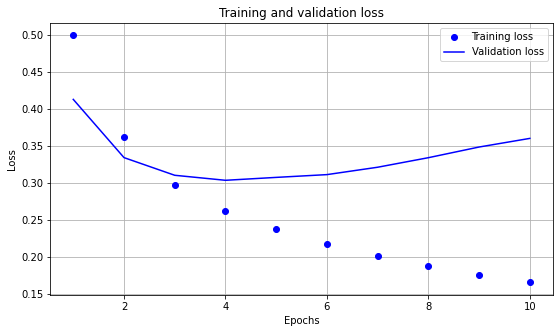

In [24]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

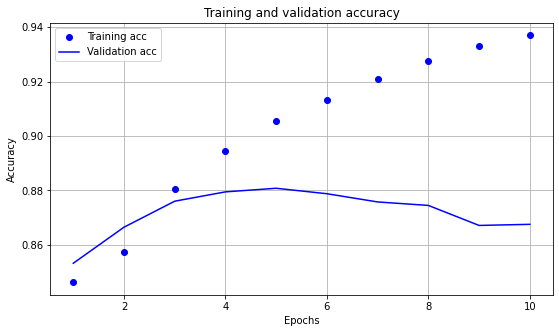

In [25]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [26]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"Amazing.. get it"
score: 1.000000
actual: 1

input:
"+ Les sorcières s'en mêlent"
score: 1.000000
actual: 1

input:
"7. Solid Eurogame. Too much luck for my taste. Feels unbalanced, too. Besides: This kind of mechanism overkill wasn't cool in Mombasa, and it is not in GWT."
score: 0.000000
actual: 1

input:
"Overdone Viking theme, plodding, with runaway leader problem. Just not for me."
score: 0.000000
actual: 0

input:
"Love the theme and the game."
score: 1.000000
actual: 1

input:
"Sleeved "
score: 1.000000
actual: 1

input:
"Garritt's game"
score: 1.000000
actual: 1

input:
"Love love love Scythe. Got all of the main expansions. But the game looses a point for me for including an expansion tease on the main game board, meaning the starting spaces for future factions, meaning you pretty much are required to get a future expansion to unlock the full game. Should be a 9 but goes down to 8"
score: 1.000000
actual: 1

input:
"a good eurogame is one that is light in complexity bu

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
## APPLY MODEL ON NON-RATED COMMENTS

In [28]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

8/8 - 0s
input:
"Kickstarted: August 2021 Estimated Delivery Date: December 2022"
score: 1.000000

input:
"Folded Space Insert including Expansions"
score: 1.000000

input:
"Kickstarter Delivery expected December 2018"
score: 1.000000

input:
"Sleeved 3d printed insert 3d printed components [A]"
score: 1.000000

input:
"Terraforming Mars: BGG User-Created Corporation Pack Terraforming Mars: Colonies Terraforming Mars: Hellas & Elysium Terraforming Mars: Penguins Promo Card Terraforming Mars: Prelude Terraforming Mars: Self Replicating Robots Promo Card Terraforming Mars: Small Asteroid Promo Card Terraforming Mars: Snow Algae Promo Card Terraforming Mars: Turmoil (Kickstarter w/boards) Terraforming Mars: Venus Next"
score: 1.000000

input:
"Jurgen, 2-4p, 3u, community solo rules"
score: 1.000000

input:
"VN pledged Eternal Pledge + Playmat US ebayed Eternal Pledge + Playmat"
score: 1.000000

input:
"Players: 1-5 Recommended: Best with 3-5 Time: 1 hour"
score: 1.000000

input:
"Prelude,

## REGRESSOR

In [29]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000019F0E0C0A90>,
             param_grid={})

In [30]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [31]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [32]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [33]:
epochs = range(1, len(mean_squared_error) + 1) 

In [34]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.51


In [35]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 1.06


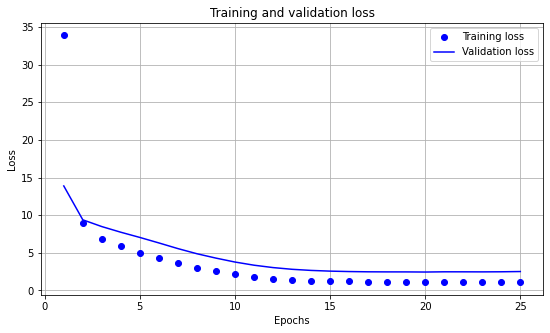

In [36]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

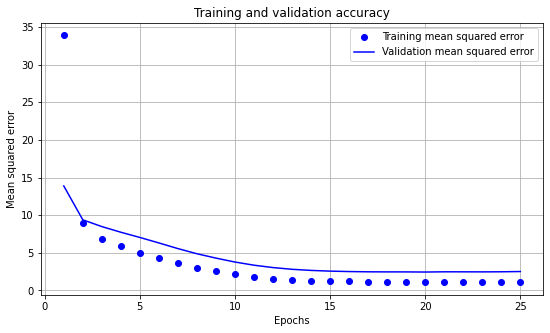

In [37]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [38]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"Amazing.. get it"
score: 8.17
actual: 10.00 

input: 
"+ Les sorcières s'en mêlent"
score: 7.68
actual: 7.50 

input: 
"7. Solid Eurogame. Too much luck for my taste. Feels unbalanced, too. Besides: This kind of mechanism overkill wasn't cool in Mombasa, and it is not in GWT."
score: 6.48
actual: 7.00 

input: 
"Overdone Viking theme, plodding, with runaway leader problem. Just not for me."
score: 3.99
actual: 4.00 

input: 
"Love the theme and the game."
score: 8.78
actual: 9.00 

input: 
"Sleeved "
score: 8.84
actual: 10.00 

input: 
"Garritt's game"
score: 8.72
actual: 9.00 

input: 
"Love love love Scythe. Got all of the main expansions. But the game looses a point for me for including an expansion tease on the main game board, meaning the starting spaces for future factions, meaning you pretty much are required to get a future expansion to unlock the full game. Should be a 9 but goes down to 8"
score: 8.76
actual: 8.00 

input: 
"a good eurogame is one that is light in co

## COMPARE CLASSIFIER VS REGRESSOR

In [39]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"+1) New Players Boards +2) New Hex Tiles +4) Monastery Boards +5) Pleasure Garden +6) The Cloisters +8) Trade Routes"
    reg score: 9.34
    clf score: 1

"Have not played enough to rate yet"
    reg score: 8.40
    clf score: 1

"Every time I opened the box - the entire task of setting this up and playing seemed too daunting. In the end, sold the first edition off (unpunched) to someone who'd enjoy it better.   Might eventually purchase a copy - but think I'm just not into dungeon crawlers."
    reg score: 6.83
    clf score: 0

"---------------------------------------- PUBLISHER: Stonemaier Games EDITION:   - VERSION:   Collector (#11053) LANGUAGE:  English ---------------------------------------- EXP + Invaders from Afar (2016) + The Wind Gambit (2017) + The Rise of Fenris (2018) PRO + Promo Pack #1 (2016): Encounter #29-#32 + Promo Pack #2 (2016): Encounter #33-#36 + Promo Pack #3 (2016): Objective #24-#27 + Promo Pack #4 (2016): Factory #13-#18 + Promo Pack #5 (2016): Power Dial

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [40]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.37 |           3698 |
| 167355 |          8.41 |           2002 |
| 167791 |          8.20 |           8521 |
| 169786 |          8.09 |           7524 |
| 170216 |          7.97 |           4365 |


In [41]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [42]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 162886 |          8.21 |            327 |
| 167355 |          8.25 |            213 |
| 167791 |          8.32 |            454 |
| 169786 |          8.20 |            612 |
| 170216 |          8.19 |            329 |


In [43]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [44]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/E8qBDKe...","<a href=""https://boardgamegeek.com/boardgame/2...",9.000000,7.618282,8.232379,1,2022
1,"<img src=""https://cf.geekdo-images.com/Q96PxRV...","<a href=""https://boardgamegeek.com/boardgame/3...",6.938706,6.135422,6.906359,2,2021
2,"<img src=""https://cf.geekdo-images.com/3P1cMmZ...","<a href=""https://boardgamegeek.com/boardgame/2...",7.095238,8.356588,7.967054,3,2021
3,"<img src=""https://cf.geekdo-images.com/utvlrrm...","<a href=""https://boardgamegeek.com/boardgame/3...",3.000000,8.791581,7.343686,4,2021
4,"<img src=""https://cf.geekdo-images.com/9Upl9mD...","<a href=""https://boardgamegeek.com/boardgame/2...",9.028571,8.195788,8.560131,5,2021


In [45]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [46]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Weather Machine,9.000000,7.618282,8.232379,1,2022
2,,Descent: Legends of the Dark,6.938706,6.135422,6.906359,2,2021
3,,The Great Wall,7.095238,8.356588,7.967054,3,2021
4,,Corrosion,3.000000,8.791581,7.343686,4,2021
5,,Dice Realms,9.028571,8.195788,8.560131,5,2021


In [47]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,10.000000,7.673881,8.139105,48,2022
2,,Dice Realms,9.028571,8.195788,8.560131,5,2021
3,,Weather Machine,9.000000,7.618282,8.232379,1,2022
4,,Last Light,8.936364,8.239036,8.829082,27,2022
5,,Eclipse: Second Dawn for the Galaxy,8.726327,8.183322,8.644595,39,2020


In [48]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Last Light,8.936364,8.239036,8.829082,27,2022
2,,Eclipse: Second Dawn for the Galaxy,8.726327,8.183322,8.644595,39,2020
3,,Brass: Birmingham,8.676521,8.280542,8.641616,29,2018
4,,Dice Realms,9.028571,8.195788,8.560131,5,2021
5,,Gloomhaven: Jaws of the Lion,8.552040,8.129974,8.513428,31,2020


In [49]:
# model.save('saved_model\my_model')

In [50]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [51]:
# some examples on "long" comments vs short comments

In [52]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [53]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"Would consider used when newness wears off and price comes down.  Unique concept that would add a new flavor to my collection."
score: 3.76

"Due May 2020 - sold straight away in shrink. I’d like to play this still but it was worth too much to hold on to."
score: 6.25

"I finally decided I love the idea of the land fighting back against the invaders too much not to own this game."
score: 6.64

"Condition:    NIS (New In Shrink) Acquisition:  8/12/2020 Source:       GameNerdz MSRP:         $59.99 Paid Price:   $49.99"
score: 6.81

"+ Expansiones: - Ciclo El Legado de Dunwich - Ciclo Camino a Carcosa  + PODs: - La maldición de rougarou - Carnevale de horrores  + Escenarios independientes: - Guardianes del Abismo - Asesinato en el Hotel Excelsior - La masa que lo devoraba todo - La guerra de los Dioses Exteriores"
score: 7.00

"Have played the first couple scenarios. Really dug it. Waiting to get deeper into it before reviewing."
score: 7.14

"Just as I was done spending one month's sala

## RANDOM FOREST - TEST

In [54]:
# no support for Windows at the moment - waiting for it to test